# Projecting Food Insecurity Rates in the US by County
## Feature Selection & Modeling Process
### Flatiron School Data Science Capstone<br>By Khyatee Desai

This notebook contains the feature selection and modeling process to predict food insecurity rates based on a number of features, both from the original datasets, as well as engineered features which were created in feature_engineering.ipynb.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import sys
sys.path.insert(0, '../src/')
from functions import *

### Import cleaned dataset

In [2]:
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
    
# remove features not needed for modeling
df.drop([ 'coc_number','Low Threshold Type', 'High Threshold Type',
       'State', 'County', 'State/County'],axis=1, inplace=True)
df.head(3)

,FIPS,Rent,Year,Houseless_rate,Sheltered_rate,Unsheltered_rate,TOT_POP,TOT_MALE,TOT_FEMALE,TOT_WHITE,TOT_BLACK,TOT_NATIVE,TOT_ASIAN,TOT_PACIFIC,TOT_LATINX,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Houseless_rate_X_Sheltered_rate,Rent_X_Percent_Black,Houseless_rate_X_Percent_male,Houseless_rate_X_Percent_female,Rent_X_Percent_working,Sheltered_rate_X_Percent_male,Sheltered_rate_X_Percent_female,Rent_X_Cost Per Meal,Rent_X_Percent_female,Rent_X_Percent_male,Rent_X_Unemployment_rate,Percent_asian_X_Percent_working,Unemployment_rate_X_Percent_Black,Unsheltered_rate_X_Percent_working,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_working,Cost Per Meal_X_Percent_working,Cost Per Meal_X_Percent_asian,Unsheltered_rate_X_Percent_asian,Rent_X_Percent_asian,Sheltered_rate_X_Percent_white,Percent_pacific_X_Percent_working,Percent_Black_X_Percent_working,Unsheltered_rate_X_Percent_male,Unsheltered_rate_X_Percent_female,Rent_X_Food_retail_per_person,Houseless_rate_X_Percent_Black,Cost Per Meal_X_Percent_male,Cost Per Meal_X_Percent_female,Sheltered_rate_X_Percent_Black,Houseless_rate_X_Unemployment_rate,Rent_X_Percent_white,Percent_Black_X_Percent_native,Unemployment_rate_X_Percent_male,Unemployment_rate_X_Percent_female,Unsheltered_rate_X_Cost Per Meal,Percent_Black_X_Percent_pacific,Percent_female_X_Percent_working,Percent_male_X_Percent_working,Cost Per Meal_X_Percent_Black,Percent_white_X_Percent_native,Percent_female_X_Percent_asian,Percent_male_X_Percent_asian,Percent_white_X_Percent_pacific,Sheltered_rate_X_Percent_pacific,Houseless_rate_X_Percent_pacific,Houseless_rate_X_Percent_working,Houseless_rate_X_Percent_asian,TOT_POP_X_Total_food_retail,Num_restaraunts_X_Num_grocery,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,Lo_thresh_SNAP,Lo_thresh_SNAP_other,Hi_thresh_SNAP,Hi_thresh_SNAP_other,Hi_thresh_other
0,01073,1019.995960,2014,0.001396,0.000961,0.000435,659972.0,312491.0,347481.0,355635.0,284082.0,2029.0,10378.0,347.0,24099.0,0.197,2.93,483.0,2693.0,400.0,312131.0,292505.0,19626.0,6.3,0.473491,0.526509,0.538864,0.430446,0.003074,0.015725,0.000526,0.036515,0.461136,0.472946,3576.0,0.005418,0.000001,439.052706,0.000661,0.000735,482.402827,0.000455,0.000506,2988.588162,537.036747,482.959213,6425.974545,0.007437,2.711807,0.000206,3.394842,2.979559,1.385731,0.046074,0.000007,16.039344,0.000518,0.000249,0.203577,0.000206,0.000229,5.526758,0.000601,1.387330,1.542670,0.000414,0.008793,549.638868,0.001323,2.982995,3.317005,0.001274,0.000226,0.249010,0.223936,1.261205,0.001657,0.008279,0.007446,0.000283,5.052135e-07,7.338020e-07,0.000660,0.000022,2.360060e+09,1077200.0,6.927554,-6.574399,-6.947657,-7.740715,13.399953,1.075002,6.180017,7.898411,5.991465,1.840550,-0.747622,-0.641487,-0.618292,-0.842934,-5.784654,-4.152509,-7.550628,-0.748774,8.182000,-5.217953,1,0,0,0,1
19,01117,1229.755051,2014,0.001396,0.000961,0.000435,206280.0,100304.0,105976.0,174094.0,24247.0,805.0,4403.0,101.0,11872.0,0.105,3.37,1.0,743.0,2706.0,107208.0,102400.0,4808.0,4.5,0.486252,0.513748,0.843969,0.117544,0.003902,0.021345,0.000490,0.057553,0.156031,0.519721,3450.0,0.016725,0.000001,144.550469,0.000679,0.000717,639.129239,0.000467,0.000494,4144.274520,631.784571,597.970480,5533.897727,0.011093,0.528949,0.000226,3.797862,2.338743,1.751459,0.071932,0.000009,26.248844,0.000811,0.000254,0.061090,0.000211,0.000223,20.567456,0.000164,1.638668,1.731332,0.000113,0.006280,1037.87558

# Model 1: All Features
The first model is a simple linear regression model that trains on data from years 2010-2019, uses *all* engineered features created in feature_engineering.ipynb.

### Train/Test Split
I decided to drop the Rent prices column altogether for modeling, given that rent data was only available for major cities, and therefore would greatly limit the amount of data I would have available for modeling.

In [32]:
# Limit the year and drop rows containing null values in either of the specified columns.
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Num_grocery','Unsheltered_rate'])

# drop the Rent column, and all engineers features using the rent column
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)

# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop([ 'FIPS','FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)

In [33]:
df_model.shape

(19330, 100)

### Model 1
The model uses 19330 observations (seen above) and uses Cross Validation with 5 folds. It produces a Train/Test R-Squared value of about 0.65, an average Train/Test RMSE of 0.0258, and a mean cross validation score of 0.586.

In [34]:
# Instantiate Linear Regression model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

# R2 of training and test set
print('R2 Train:',model_1.score(X_train, y_train))
print('R2 Test:',model_1.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

scores =cross_val_score(model_1, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.6523485833705094
R2 Test: 0.6384989693722147
RMSE Train: 0.025753120713524345
RMSE Test: 0.02596605020339344 

CV Scores: [0.66413559 0.5680553  0.63006446 0.64081065 0.4298332 ]
Mean CV Score: 0.5865798397098055


# Model 2: Remove Outliers
The EDA notebook included a section on inspecting which features have the largest outliers, using box and whisker plots. The following cell focuses on the features with highest outliers: 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'TOT_BLACK', 'TOT_ASIAN','TOT_WHITE', 'TOT_LATINX','Total_workforce', and 'Employed'

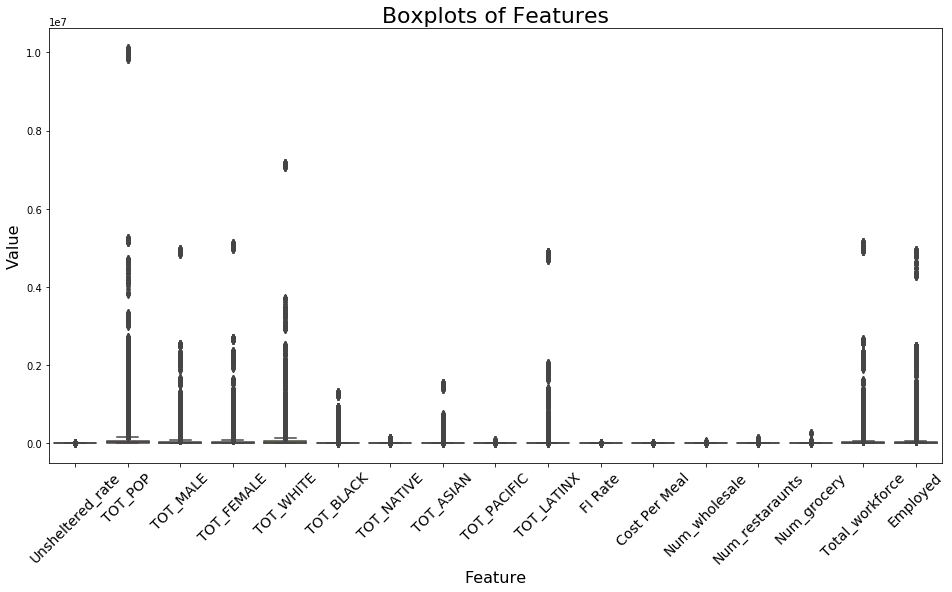

In [8]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df.iloc[:,5:22]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':16});
plt.xlabel('Feature', fontdict={'fontsize':16});
plt.xticks(rotation=45,fontsize=14);


## Remove Outliers
The following cell iterates over each feature with outliers, and if the feature has obsrvations *greater* than +/- 2 standard deviations of the mean, it reduces outliers to +/- 2 standard deviations from the mean of that feature.

In [9]:
# Bring outliers down/up to 2 standard deviations from the mean 
features = ['TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'TOT_BLACK', 'TOT_ASIAN','TOT_WHITE', 'TOT_LATINX',
            'Total_workforce', 'Employed']

df_out = df.copy()
for feat in features:
    abv_2_std = df_out[feat].mean()+ 2* df_out[feat].std()
    below_2_std = df_out[feat].mean()- 2* df_out[feat].std()
    conditions = [df_out[feat]>abv_2_std, df_out[feat]<below_2_std]
    choices = [abv_2_std, below_2_std]
    df_out[feat] = np.select(conditions, choices, df_out[feat])


### Visualize Again
After reducing outliers, the boxplots are visualized again:

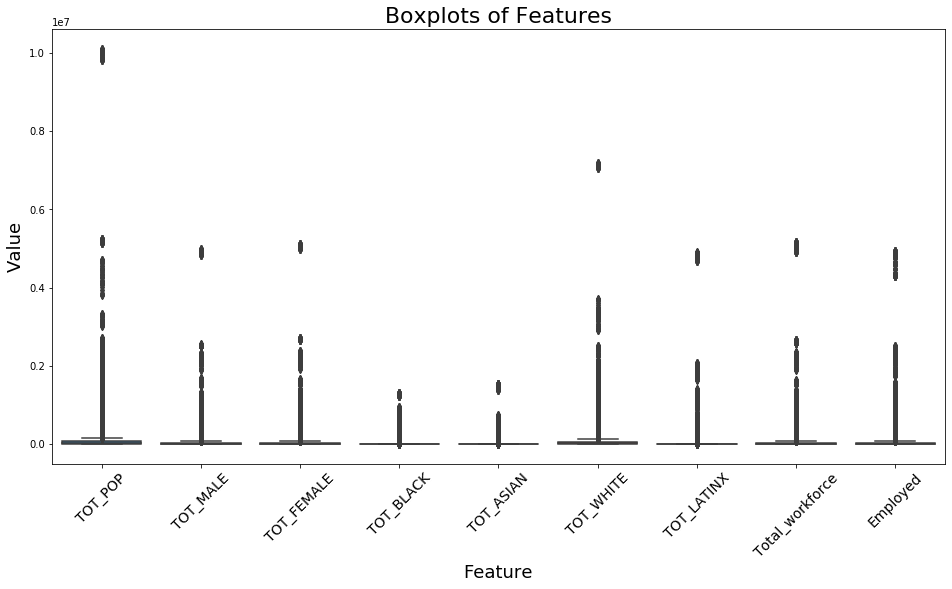

In [10]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df[features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':18});
plt.xlabel('Feature', fontdict={'fontsize':18});
plt.xticks(rotation=45,fontsize=14);

## Train/Test Split 2
Perform train/test split similarly as above, after massive outliers have been reduced

In [11]:
# Limit the year and drop null values
df_model = df_out[df_out.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Num_grocery','Unsheltered_rate'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Model 2
Re-run the model using the same process as model 1, now on data with reduced outliers.<br>
Model 2 produces a slightly better Train/Test R-Squared value of about 0.76, a worse average Train/Test RMSE of about 0.0214, and a much lower mean cross validation score of 0.503.<br>For this reason, outliers are retained in the following models.  

In [12]:
# Instantiate Linear Regression model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
y_train_pred = model_2.predict(X_train)
y_test_pred = model_2.predict(X_test)

# R2 of training and test set
print('R2 Train:',model_2.score(X_train, y_train))
print('R2 Test:',model_2.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(model_2, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.7596145847197255
R2 Test: 0.7565074503968026
RMSE Train: 0.021353798464866076
RMSE Test: 0.02154462952389605
CV Scores: [0.67619061 0.58406913 0.6281232  0.42754502 0.20125642]
Mean CV Score: 0.5034368750608141


# Feature Selection
The following processes use a few different feature selection methods to determine the optimal features for the MVP model
### Train/Test Split 3 
Need to do this again to add outliers back in

In [8]:
# create df_model again, with outliers included this time
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Num_grocery','Unsheltered_rate'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Multicollinearity 
Multicollinearity can create noise within the data. A heatmap is produced from correlation matrix in the EDA.ipynb notebook, which highlights that houseless rate, sheltered/unsheltered rates, and all of the race-related features are highly correlated with one another. The following cells explain the correlation between feature pairs even more:
### Inspect correlation between each feature pair
The correlation matrix is reformatted to show the correlation between each feature pair - we see that demographics features, employment-related features, and houselessness-related features are all highly correlated, which is to be expected.

In [14]:
# reformat the correlation matrix and output top 15 pairs
corr=df_model.iloc[:,1:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.95) & (corr.correlation <1.0)][:15]

,correlation,pairs
2836,1.000000,"(Percent_PoC, Percent_white)"
2260,1.000000,"(Percent_white, Percent_PoC)"
488,0.999949,"(TOT_FEMALE, TOT_POP)"
296,0.999949,"(TOT_POP, TOT_FEMALE)"
391,0.999945,"(TOT_MALE, TOT_POP)"
295,0.999945,"(TOT_POP, TOT_MALE)"
489,0.999789,"(TOT_FEMALE, TOT_MALE)"
393,0.999789,"(TOT_MALE, TOT_FEMALE)"
1667,0.999374,"(Total_workforce, Employed)"
1763,0.999374,"(Employed, Total_workforce)"


### Varience Inflation Factor
Variance inflation factor (VIF) helps quantifies the severity of multicollinearity in a regression model, by comparing variance of the model with different terms. High VIF scores indicate severe multicollinearity. The following cell creates a dataframe only with features that have VIF scores below 10:

In [15]:
# create a vif dataframe with all features of scores below 10
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif_features = vif[vif['VIF Factor'] <10]['features']
vif[vif['VIF Factor'] <40].head()

,VIF Factor,features
11,38.020429,TOT_LATINX
27,2.072117,Percent_latinX
31,3.477212,Food_retail_per_person
32,10.846655,Houseless_rate_X_Sheltered_rate
44,5.112595,Unsheltered_rate_X_Percent_asian


## Model 3: Removed Multicollinear Features
Model 3 uses only features with VIF scores below 10. It performs significantly worse than the prior models, with a Train/Test R-Squared value of about 0.46, a Train/Test RMSE of about 0.031, and a much lower mean cross validation score of 0.40.


In [16]:
# Instantiate Linear Regression model
model_3 = LinearRegression()
model_3.fit(X_train[vif_features], y_train)
y_train_pred = model_3.predict(X_train[vif_features])
y_test_pred = model_3.predict(X_test[vif_features])

# R2 of training and test set
print('R2 Train:',model_3.score(X_train[vif_features], y_train))
print('R2 Test:',model_3.score(X_test[vif_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(model_3, X[vif_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.4502406642367527
R2 Test: 0.47253602614027945
RMSE Train: 0.03224563440116533
RMSE Test: 0.03184366752099461
CV Scores: [0.43264855 0.40267581 0.31255371 0.37427261 0.40375203]
Mean CV Score: 0.38518054085511233


## Model 4: K-Best Selected Features
Model 4 uses `SelectKBest()` to determine the best k featues to use in a model. The cell below loops through a number of k values to determine the optimal one.

In [17]:
# # determine optimal k with a loop 

# for k in range(90,97):
#     selector = SelectKBest(f_regression, k=k)
#     selector.fit(X_train, y_train)
#     kbest_features = X_train.columns[selector.get_support()]
#     model_3 = LinearRegression()
#     model_3.fit(X_train[kbest_features], y_train)
#     y_test_pred = model_3.predict(X_test[kbest_features])
#     print(k,'\n', model_3.score(X_test[kbest_features],y_test))
#     print(np.mean(cross_val_score(model_1, X[kbest_features], y, cv=5,  scoring='r2')))


### Model 4
The best k value is determined to be 93, so model 4 is run with those features. Model 4 performs significantly better than others, with an average **R-squared value of .79**, an **RMSE of .0199**, and an average **cross validation score of 0.743.**

In [18]:
# run model with best k features
selector = SelectKBest(f_regression, k=93)
selector.fit(X_train, y_train)
kbest_features = X_train.columns[selector.get_support()]

model_4 = LinearRegression()
model_4.fit(X_train[kbest_features], y_train)
y_train_pred = model_4.predict(X_train[kbest_features])
y_test_pred = model_4.predict(X_test[kbest_features])

# R2 of training and test set
print('R2 Train:',model_4.score(X_train[kbest_features], y_train))
print('R2 Test:',model_4.score(X_test[kbest_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

# cross validation scores
scores =cross_val_score(model_4, X[kbest_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.7906388337152134
R2 Test: 0.7914038614333575
RMSE Train: 0.01989906559436821
RMSE Test: 0.02002533601121146
CV Scores: [0.71579578 0.72403561 0.65984329 0.82352845 0.79295523]
Mean CV Score: 0.7432316721536868


## Model 5: Recursive Feature Elimination
Recursive feature elimination is used to iteratively remove features and rerun the model, in order to find an optimal set of features to use.
### Run RFE to retrieve set of rfe_features

In [9]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

### Model 5:
The RFE model performs approximately as well as the Select K Best model, with an average **R-squared value of .79**, an **RMSE of .0198**, and an average **cross validation score of 0.749**.

In [10]:
model_5 = LinearRegression()
model_5.fit(X_train[rfe_features], y_train)
y_train_pred = model_5.predict(X_train[rfe_features])
y_test_pred = model_5.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:',model_5.score(X_train[rfe_features], y_train))
print('R2 Test:',model_5.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(model_5, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.7934301355325468
R2 Test: 0.7873936216409474
RMSE Train: 0.01990089925829045
RMSE Test: 0.019805454833467243 

CV Scores: [0.73334671 0.73177446 0.6606341  0.81991234 0.7968398 ]
Mean CV Score: 0.7485014824064351


# Evaluation

## Compare predictions to actual values
View FI test predictions alongside the actual FI values - predicitons are visually close to the actual values which is reassuring

In [11]:
test_set = pd.concat([X_test, y_test],axis=1).reset_index()
df_preds = pd.concat([test_set,pd.Series(y_test_pred)],axis=1).rename(columns={0:'Y Test Preds'})
df_preds[['FI Rate','Y Test Preds']].sample(10)

,FI Rate,Y Test Preds
3415,0.12600,0.139680
4246,0.13550,0.156497
2622,0.16900,0.151228
2582,0.11800,0.124797
608,0.10575,0.100226
4825,0.12300,0.143292
3292,0.16300,0.150988
2237,0.13200,0.111151
2365,0.14900,0.120372
4448,0.11750,0.118349


## Final Model Feature Importance
inspect all the rfe features used in the final model

In [39]:
rfe_features

Index(['Houseless_rate', 'Sheltered_rate', 'Unsheltered_rate', 'TOT_POP',
       'TOT_MALE', 'TOT_FEMALE', 'TOT_WHITE', 'TOT_BLACK', 'TOT_NATIVE',
       'TOT_ASIAN', 'TOT_PACIFIC', 'Cost Per Meal', 'Num_wholesale',
       'Num_restaraunts', 'Num_grocery', 'Total_workforce', 'Employed',
       'Unemployed', 'Unemployment_rate', 'Percent_male', 'Percent_female',
       'Percent_white', 'Percent_Black', 'Percent_native', 'Percent_asian',
       'Percent_pacific', 'Percent_latinX', 'Percent_PoC', 'Percent_working',
       'Total_food_retail', 'Food_retail_per_person',
       'Houseless_rate_X_Sheltered_rate', 'Houseless_rate_X_Percent_male',
       'Houseless_rate_X_Percent_female', 'Sheltered_rate_X_Percent_male',
       'Sheltered_rate_X_Percent_female', 'Percent_asian_X_Percent_working',
       'Unemployment_rate_X_Percent_Black',
       'Unsheltered_rate_X_Percent_working',
       'Unemployment_rate_X_Percent_white',
       'Unemployment_rate_X_Percent_working',
       'Cost Per Meal_

### Model Coefficients
View the ten highest coefficients alongside their corresponding features -- from the output, we see that Houseless rates intersected with race are the highest predictors for food insecurity, which is not suprising after doing EDA on this data.

In [35]:
sorted(list(zip(model_5.coef_.tolist(), X_test.columns)), reverse=True)[:10]

[(25148.43406913098, 'Unsheltered_rate'),
 (25128.704386069712, 'Houseless_rate_X_Sheltered_rate'),
 (25121.82280037445, 'Houseless_rate_X_Percent_male'),
 (25102.09215732087, 'Sheltered_rate'),
 (12589.751692018015, 'Percent_Black_X_Percent_working'),
 (12563.140386645082, 'Sheltered_rate_X_Percent_male'),
 (12558.682413724084, 'Unsheltered_rate_X_Percent_male'),
 (12538.952694053738, 'Houseless_rate_X_Percent_female'),
 (118.73999449300752, 'Houseless_rate_X_Percent_working'),
 (84.2136249355529, 'Unsheltered_rate_X_Percent_asian')]

## Visualize Predicitons on a Map
The following cells make predicitions on all 2018 data, using the best RFE model, and then visualize these predicitons in a choropleth map alongside the actual FI values for 2018.

In [12]:
# Create dataframe for just 2018
df_18 = df[df.Year.isin(['2018'])].dropna(subset=['Num_grocery','Unsheltered_rate'])
for col in df_18.columns:
    if 'Rent' in col:
        df_18.drop(col,axis=1,inplace=True)

# separate target and features
y = df_18['FI Rate']
X = df_18.drop(['FIPS', 'FI Rate','Year'],axis=1)

Make predictions and inspect preds vs actual values side-by-side

In [13]:
# Use RFE model to predict on all 2018 data, and create new column in dataframe for predictions
preds_2018 = model_5.predict(X[rfe_features])
        
df_preds = pd.concat([df_18.reset_index() ,pd.Series(preds_2018)],axis=1,).rename(columns={0:'Predicted FI Rate'})
df_preds[['FI Rate','Predicted FI Rate']].sample(10)


,FI Rate,Predicted FI Rate
1993,0.144,0.130654
960,0.128,0.133138
138,0.103,0.178135
1991,0.093,0.112803
1623,0.199,0.159873
740,0.148,0.174459
2425,0.079,0.109419
2855,0.113,0.127228
202,0.143,0.145426
1307,0.069,0.111107


### Create Choropleth maps of predictions
The maps below indicate that the model was able to capture the general trends of food insecurity, especially in places which are the most significantly impacted. The model did not perform as well at capturing the severity of FI rates in certain areas, such as Maine, the Pacific Northwest, and the Southeast.

White areas are counties which contained missing values, due to a lack of data specific to a feature for the year 2018.

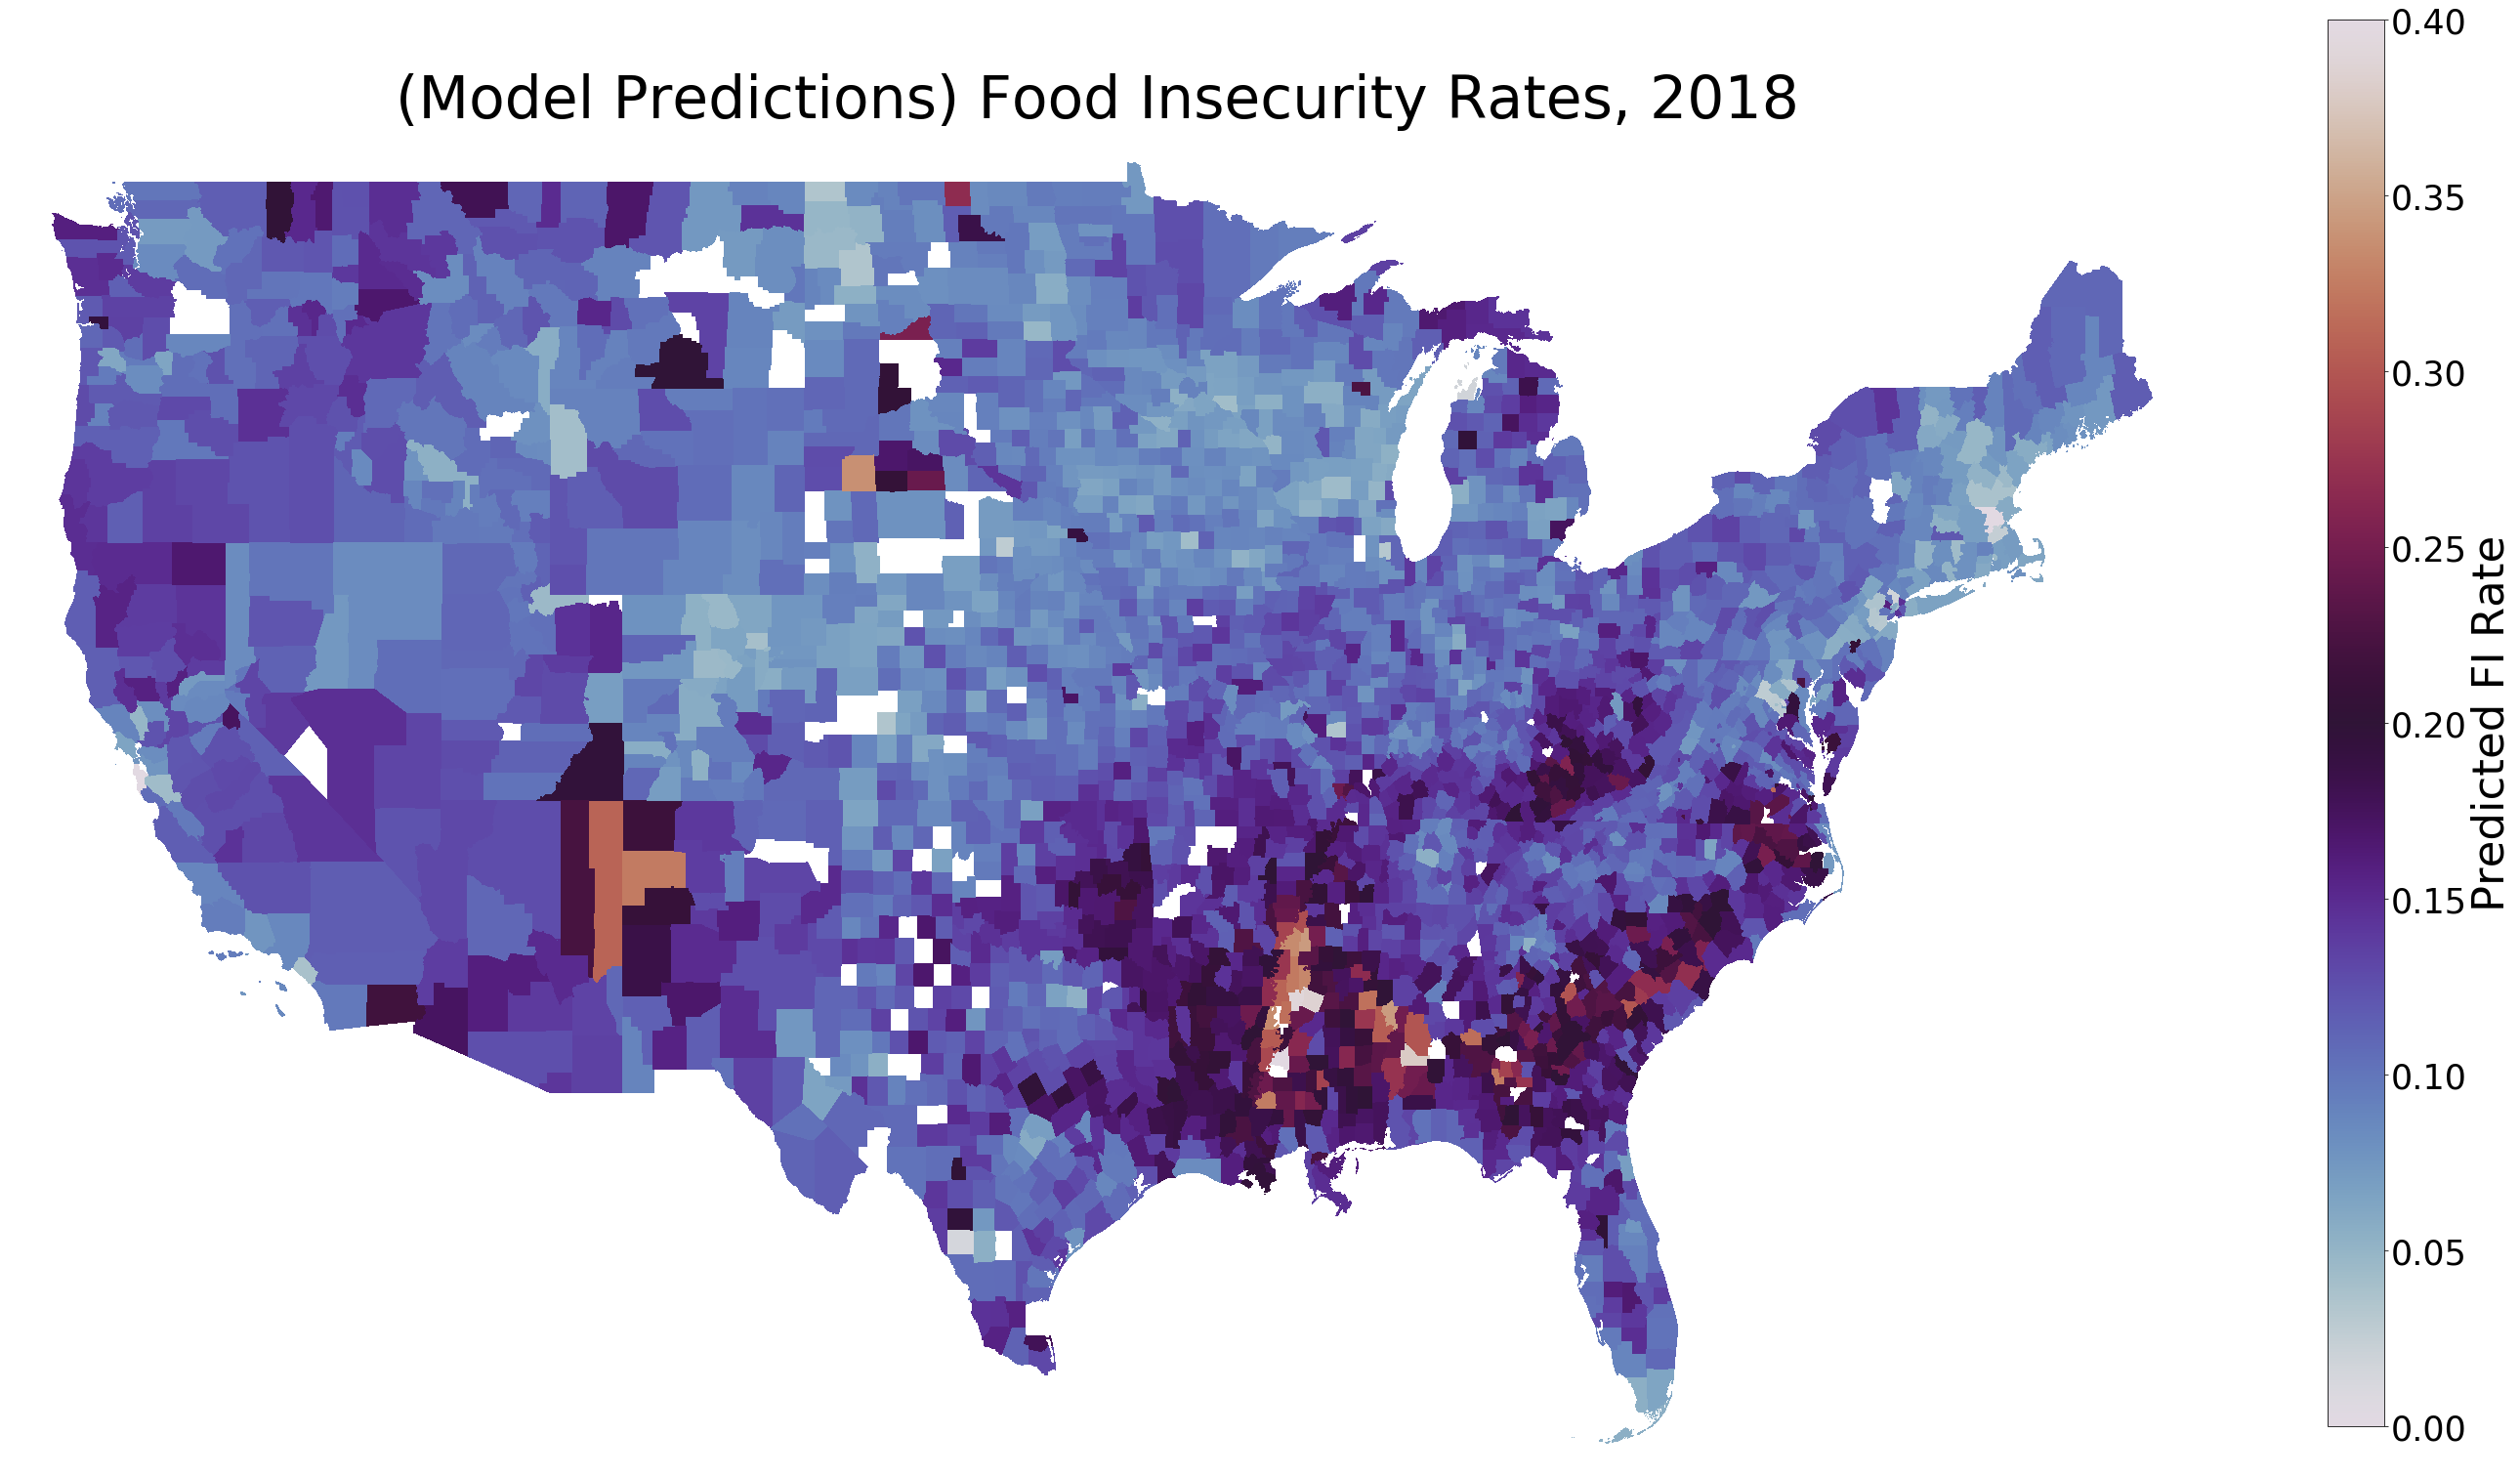

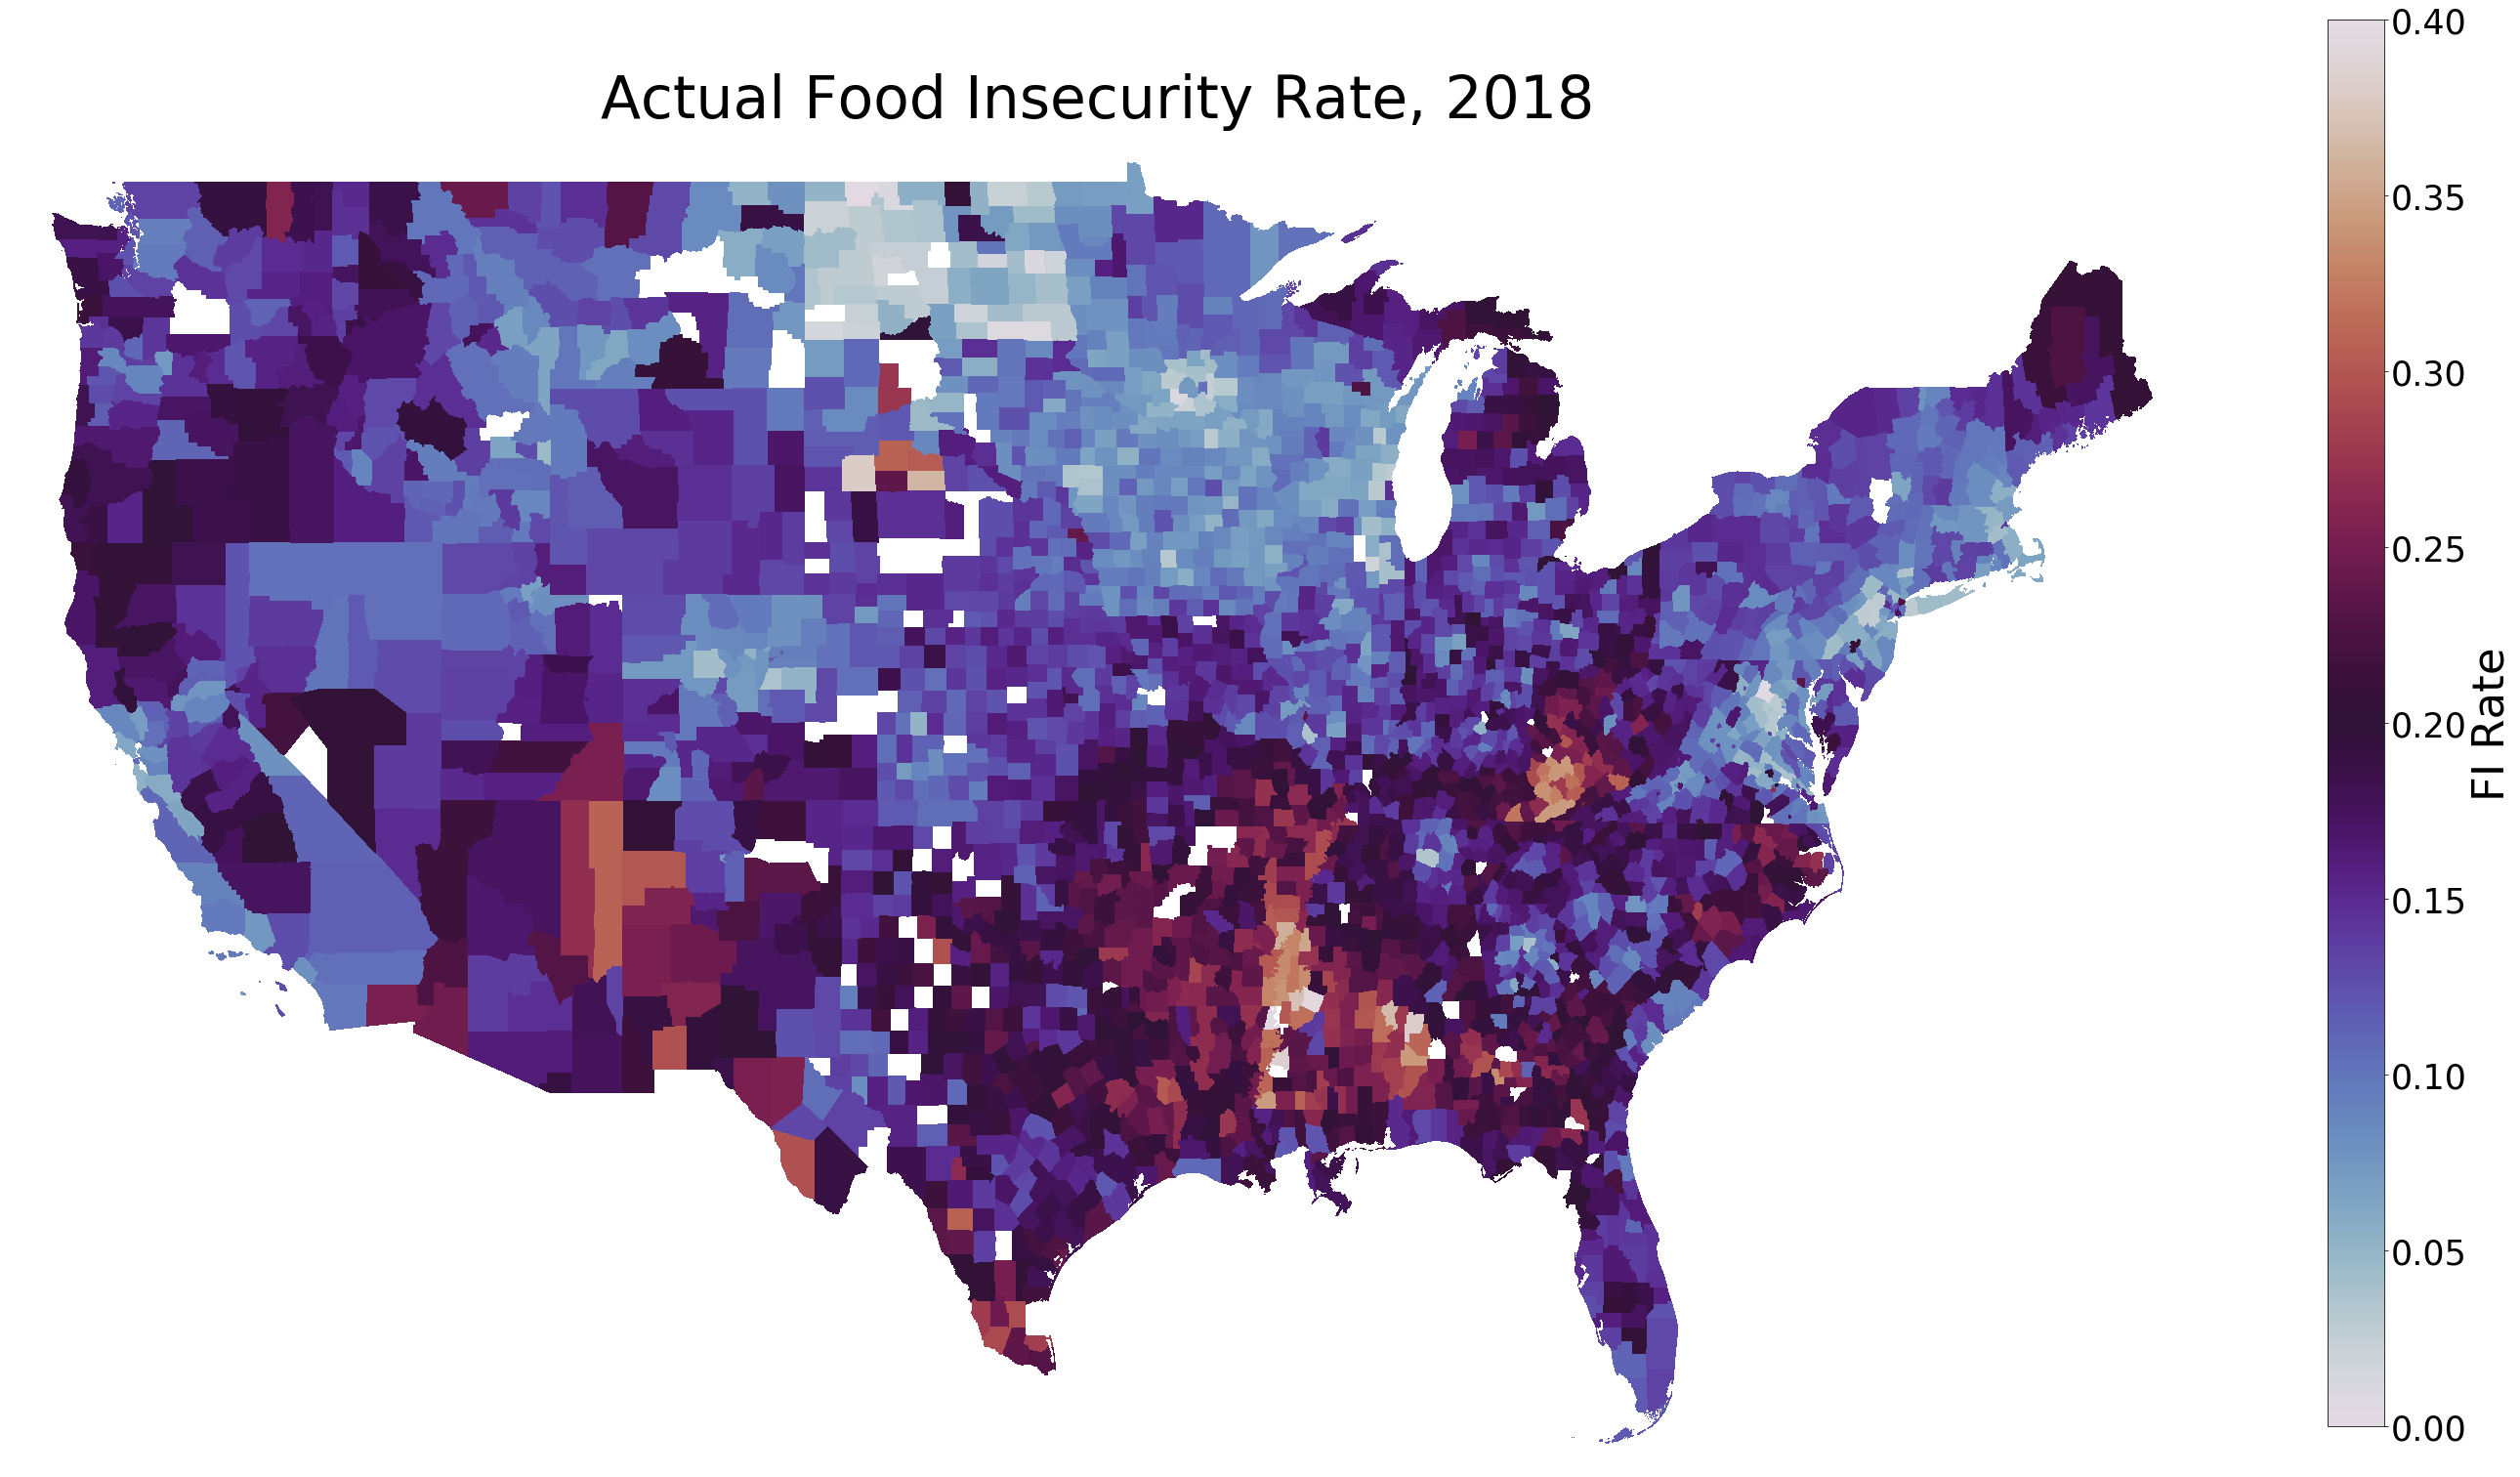

In [15]:
choropleth(df_preds,'Predicted FI Rate','2018','twilight','(Model Predictions) Food Insecurity Rates')
choropleth(df_preds,'FI Rate','2018','twilight', 'Actual Food Insecurity Rate')

# Conclusion
The final RFE Model 5 was able to explain about 75% of the variance in the data, based on a cross validation R2 score of 0.7486, and was off on predictions by an average of 2%, based on Test RMSE score. The most important features used in this model were shown to be Unsheltered_rate_X_Percent_asian, Sheltered_rate_X_Percent_white, Sheltered_rate_X_Percent_Black, Houseless_rate_X_Percent_asian, and Unsheltered_rate_X_Percent_male, based on model coefficients. This indicates that both Houselessness and race play a very critical role in determining the likelihood of food insecurity, but especially so when they are combined (ie. someone who is both Black and houseless.)<br>The choropleth maps on 2018 FI Rate predictions indicate that the model was able to capture the general trend of food insecurity, particularly in places that are hardest hit, however there is room to improve the model's ability to explain even more variance in the data, potentially by adding more features in the next iteration, such as household income, food assistance programs, age, and trasportation access.